# **Drive 연결 및 라이브러리 임포트**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

In [3]:
zipfile.ZipFile('./drive/MyDrive/bigdata/stock-data.zip').extractall()
zipfile.ZipFile('./drive/MyDrive/bigdata/gold-data.zip').extractall()
zipfile.ZipFile('./drive/MyDrive/bigdata/crypto-data.zip').extractall()

# LSTM

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [ ]:
#read data
# kernels let us navigate through the zipfile as if it were a directory

# trying to read a file of size zero will throw an error, so skip them
# filenames = [x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(x) > 0]
# filenames = random.sample(filenames,1)
filenames = ['./Stocks/prk.us.txt', './Stocks/bgr.us.txt', './Stocks/jci.us.txt', './Stocks/aa.us.txt', './Stocks/fr.us.txt', './Stocks/star.us.txt', './Stocks/sons.us.txt', './Stocks/ipl_d.us.txt', './Stocks/sna.us.txt', './Stocks/utg.us.txt']
filenames = [filenames[1]]
print(filenames)

data = []
for filename in filenames:
    df = pd.read_csv(filename, sep=',')
    filename = filename.split(sep='/')[2]
    label, _, _ = filename.split(sep='.')
    df['Label'] = filename
    df['Date'] = pd.to_datetime(df['Date'])
    data.append(df)

In [ ]:
print(type(data[0]))

In [ ]:
r = lambda: random.randint(0,255)
traces = []

for df in data:
    clr = str(r()) + str(r()) + str(r())
#     df = df.sample(n=100, replace=True)
    df = df.sort_values('Date')
#     print(df['Label'])
    label = df['Label'].iloc[0]

    trace = plotly.graph_objs.Scattergl(
        x=df['Date'],
        y=df['Close'],
        mode='lines+text',
        line=dict(
            color = "rgb(255,0,0)"
        )
    )
    traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot',
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')

In [ ]:
dd = data[0]
print(dd)

In [ ]:
dd = dd.drop(['Label'], axis=1)
print(dd)

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(dd.Open)
ax[1].plot(dd.Close)

In [ ]:
df = data[0]
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data[0]["Date"][-(2*window_len+1):])[0]

#Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [ ]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

In [ ]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [ ]:
#https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

# XGBoost

XGBoost

In [4]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="A Figure Displayed with the 'colab' Renderer"
)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**plotly colab에서 출력하기 위한 메소드, 출력하는 모든 셀에서 실행 해야 한다.**

In [5]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

**Class XGBoost**

plot은 나중에 따로 빼는게 좋을듯

In [101]:
def plot_ohcp(c):
  fig = make_subplots(rows=2, cols=1)

  fig.add_trace(go.Ohlc(x=c.df.Date,
                        open=c.df.Open,
                        high=c.df.High,
                        low=c.df.Low,
                        close=c.df.Close,
                        name='Price'), row=1, col=1)

  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.Volume, name='Volume'), row=2, col=1)

  fig.update(layout_xaxis_rangeslider_visible=False)
  fig.show(renderer="colab")

def plot_decompose(c):
  df_close = c.df[['Date', 'Close']].copy()
  df_close = df_close.set_index('Date')
  df_close.head()

  decomp = decompose(df_close, period=365)
  fig = decomp.plot()
  fig.set_size_inches(20, 8)

def plot_moving_average(c):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.EMA_9, name='EMA 9'))
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.SMA_5, name='SMA 5'))
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.SMA_10, name='SMA 10'))
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.SMA_15, name='SMA 15'))
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.SMA_30, name='SMA 30'))
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.Close, name='Close', opacity=0.2))
  fig.show(renderer="colab")

def plot_RSI(c):
  fig = go.Figure(go.Scatter(x=c.df.Date, y=c.df.RSI, name='RSI'))
  fig.show(renderer="colab")

def plot_MACD(c):
  fig = make_subplots(rows=2, cols=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.Close, name='Close'), row=1, col=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.EMA_12, name='EMA 12'), row=1, col=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.EMA_26, name='EMA 26'), row=1, col=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df['MACD'], name='MACD'), row=2, col=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df['MACD_signal'], name='Signal line'), row=2, col=1)
  fig.show(renderer="colab")

def plot_train_valid_test(c):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=c.train_df.Date, y=c.train_df.Close, name='Training'))
  fig.add_trace(go.Scatter(x=c.valid_df.Date, y=c.valid_df.Close, name='Validation'))
  fig.add_trace(go.Scatter(x=c.test_df.Date,  y=c.test_df.Close,  name='Test'))
  fig.show(renderer="colab")

def plot_prediction(c):
  predicted_prices = c.df.loc[c.test_split_idx+1:].copy()
  predicted_prices['Close'] = c.y_pred

  fig = make_subplots(rows=2, cols=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.Close,
                          name='Truth',
                          marker_color='LightSkyBlue'), row=1, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=predicted_prices.Close,
                          name='Prediction',
                          marker_color='MediumPurple'), row=1, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=c.y_test,
                          name='Truth',
                          marker_color='LightSkyBlue',
                          showlegend=False), row=2, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=c.y_pred,
                          name='Prediction',
                          marker_color='MediumPurple',
                          showlegend=False), row=2, col=1)

  fig.show(renderer="colab")

def plot_coin_prediction(c, pred):
  predicted_prices = c.df.loc[c.test_split_idx+1:].copy()
  predicted_prices['Close'] = pred

  fig = make_subplots(rows=2, cols=1)
  fig.add_trace(go.Scatter(x=c.df.Date, y=c.df.Close,
                          name='Truth',
                          marker_color='LightSkyBlue'), row=1, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=predicted_prices.Close,
                          name='Prediction',
                          marker_color='MediumPurple'), row=1, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=c.y_test,
                          name='Truth',
                          marker_color='LightSkyBlue',
                          showlegend=False), row=2, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=pred,
                          name='Prediction',
                          marker_color='MediumPurple',
                          showlegend=False), row=2, col=1)

  fig.show(renderer="colab")

In [123]:
class XGBoost():
  
  def __init__(self, dataName='CERN', isCrypto=False):
    self.DIRECTORY = './Stocks/'
    self.NAME = dataName
    self.isCrypto = isCrypto

    if isCrypto:
      self.df = pd.read_csv(dataName + '.csv', sep=',')
    else:
      self.df = pd.read_csv(os.path.join(self.DIRECTORY, self.NAME.lower() + '.us.txt'), sep=',')
    self.gold = pd.read_csv(os.path.join('monthly_csv.csv'), sep=",")
    self.gold['Date'] = pd.to_datetime(self.gold['Date'])

    if isCrypto:
      drop_cr_col = ['SNo', "Name", "Symbol", "Marketcap"]

      self.df = self.df.drop(drop_cr_col, 1)

    # 2010년 이후의 데이터만 가져가겠다.
    self.df['Date'] = pd.to_datetime(self.df['Date'])
    self.df = self.df[(self.df['Date'].dt.year >= 2010)].copy()
    self.df.index = range(len(self.df))

    if isCrypto:
      self.df = self.df[(self.df['Date'].dt.year <= 2016)].copy()

    self.df['Gold'] = 0.0

    # 금가격
    for df_idx, df_date in enumerate(self.df.Date):
      this_year, this_month = df_date.year, df_date.month

      for gold_idx, gold_date in enumerate(self.gold.Date):
        if gold_date.year == this_year and gold_date.month == this_month:
          self.df.Gold[df_idx] = self.gold.Price[gold_idx]

    self.regularization()

    self.EMA_12 = 0
    self.EMA_26 = 0

    self.add_moving_average()
    self.add_RSI()
    self.add_macd()

    self.test_split_idx, self.valid_split_idx, self.train_df, self.valid_df, self.test_df = self.init_train_params()

    self.y_train = 0
    self.X_train = 0

    self.y_valid = 0
    self.X_valid = 0

    self.y_test  = 0
    self.X_test  = 0

    self.y_pred = 0

    self.model = 0

  def add_moving_average(self):
    self.df['EMA_9'] = self.df['Close'].ewm(9).mean().shift()
    self.df['SMA_5'] = self.df['Close'].rolling(5).mean().shift()
    self.df['SMA_10'] = self.df['Close'].rolling(10).mean().shift()
    self.df['SMA_15'] = self.df['Close'].rolling(15).mean().shift()
    self.df['SMA_30'] = self.df['Close'].rolling(30).mean().shift()

  def add_RSI(self, n=14):
    close = self.df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))

    self.df['RSI'] = rsi.fillna(0)

  def add_macd(self):
    self.EMA_12 = pd.Series(self.df['Close'].ewm(span=12, min_periods=12).mean())
    self.EMA_26 = pd.Series(self.df['Close'].ewm(span=26, min_periods=26).mean())
    self.df['MACD'] = pd.Series(self.EMA_12 - self.EMA_26)
    self.df['MACD_signal'] = pd.Series(self.df.MACD.ewm(span=9, min_periods=9).mean())

  def init_train_params(self, test_size=0.15, valid_size=0.15):
    self.df['Close'] = self.df['Close'].shift(-1)
    self.df = self.df.iloc[33:] # Because of moving averages and MACD line
    self.df = self.df[:-1]      # Because of shifting close price

    test_split_idx  = int(self.df.shape[0] * (1-test_size))
    valid_split_idx = int(self.df.shape[0] * (1-(valid_size+test_size)))

    train_df  = self.df.loc[:valid_split_idx].copy()
    valid_df  = self.df.loc[valid_split_idx+1:test_split_idx].copy()
    test_df   = self.df.loc[test_split_idx+1:].copy()

    return test_split_idx, valid_split_idx, train_df, valid_df, test_df

  def drop_cols(self):
    if self.isCrypto:
      drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
    else:
      drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt']

    self.train_df = self.train_df.drop(drop_cols, 1)
    self.valid_df = self.valid_df.drop(drop_cols, 1)
    self.test_df  = self.test_df.drop(drop_cols, 1)

  def train(self):
    self.drop_cols()

    self.y_train = self.train_df['Close'].copy()
    self.X_train = self.train_df.drop(['Close'], 1)

    self.y_valid = self.valid_df['Close'].copy()
    self.X_valid = self.valid_df.drop(['Close'], 1)

    self.y_test  = self.test_df['Close'].copy()
    self.X_test  = self.test_df.drop(['Close'], 1)

    parameters = {
    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [12],
    'gamma': [0.01],
    'random_state': [42]
    }

    eval_set = [(self.X_train, self.y_train), (self.X_valid, self.y_valid)]
    model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
    clf = GridSearchCV(model, parameters)

    clf.fit(self.X_train, self.y_train)

    print(f'Best params: {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')

    model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
    model.fit(self.X_train, self.y_train, eval_set=eval_set, verbose=False)

    plot_importance(model)

    self.model = model

    self.y_pred = self.predict(model, self.X_test, self.y_test)


  def predict(self, model, pred, origin):
    y_pred = model.predict(pred)
    print(f'y_true = {np.array(origin)[:5]}')
    print(f'y_pred = {y_pred[:5]}')

    print(f'mean_squared_error = {mean_squared_error(origin, y_pred)}')
    return y_pred


  def regularization(self):
    regularization_cols = ['Open','Close', 'High', 'Low', 'Gold']

    for aCol in regularization_cols:
      self.df[aCol] /= self.df[aCol][0]

  def getModel(self):
    return self.model

In [131]:
a = XGBoost()
c = XGBoost(dataName="coin_Bitcoin", isCrypto=True)
b = XGBoost(dataName='bbw')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.4038133542056423
y_true = [3.13949779 3.14528165 3.03524987 3.06265404 3.06619627]
y_pred = [3.4053006 3.3420074 3.4032447 3.3179588 3.2051296]
mean_squared_error = 0.22782487261595255


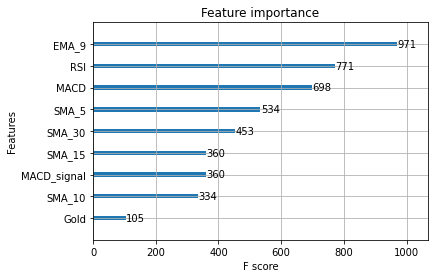

In [132]:
c.train()

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = -1.403029895540881
y_true = [2.94047845 3.14695272 3.14695272 3.17400797 3.19584204]
y_pred = [2.9920084 2.9963195 2.9923844 2.9923844 3.0088375]
mean_squared_error = 0.006580331066461947
y_true = [3.13949779 3.14528165 3.03524987 3.06265404 3.06619627]
y_pred = [3.1891472 3.1757197 3.1798155 3.169519  3.1234198]
mean_squared_error = 1.6957001035765895


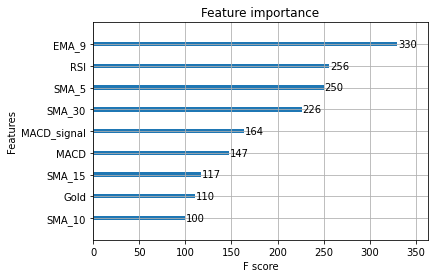

In [133]:
a.train()
crypto_pred_with_stock_train = a.predict(a.getModel(), c.X_test, c.y_test)

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = -0.23191609911344796
y_true = [2.69484536 2.62268041 2.4742268  2.49484536 2.57731959]
y_pred = [2.776174  2.742615  2.7513146 2.4981766 2.4601986]
mean_squared_error = 0.029596331764511378
y_true = [2.69484536 2.62268041 2.4742268  2.49484536 2.57731959]
y_pred = [2.8405588 2.7889214 2.7116487 2.6602716 2.6022866]
mean_squared_error = 0.01752375230217303


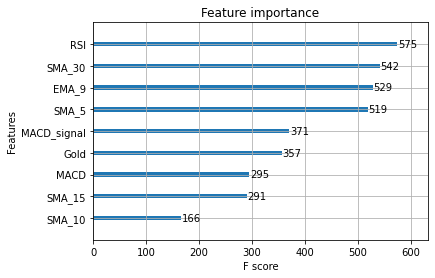

In [134]:
b.train()
stock_to_stock = a.predict(a.getModel(), b.X_test, b.y_test)

In [135]:
plot_coin_prediction(b, stock_to_stock)

In [138]:
crypto_pred_with_stock_train2 = b.predict(b.getModel(), c.X_test, c.y_test)

y_true = [3.13949779 3.14528165 3.03524987 3.06265404 3.06619627]
y_pred = [3.462454  3.4070358 3.462454  3.408414  3.3807976]
mean_squared_error = 0.514585925099395


In [139]:
plot_coin_prediction(c, crypto_pred_with_stock_train2)

In [137]:
plot_ohcp(c)

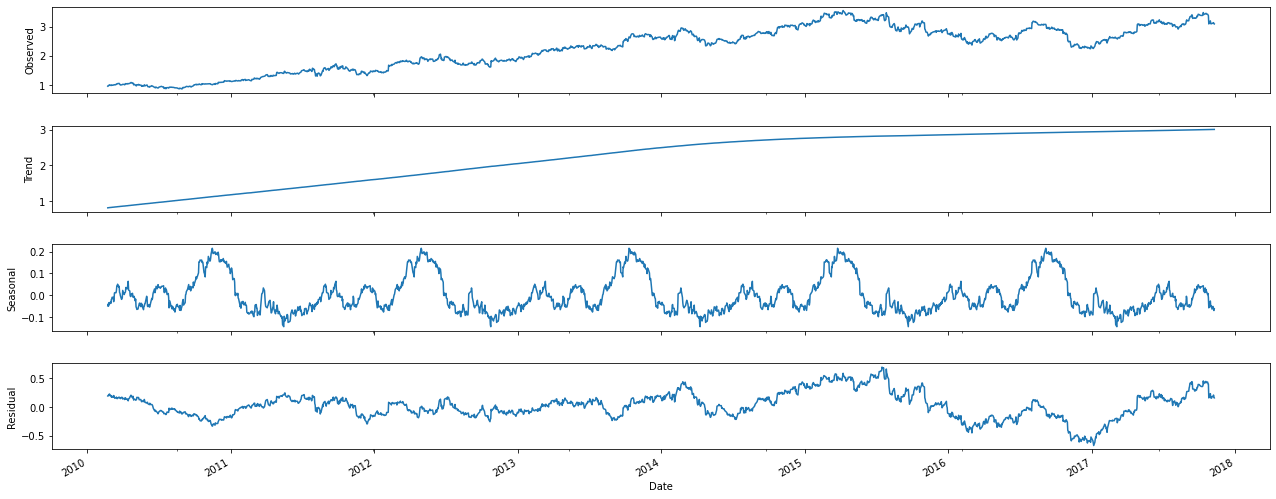

In [59]:
plot_decompose(a)

In [60]:
plot_moving_average(a)

In [61]:
plot_RSI(a)

In [62]:
plot_MACD(a)

In [63]:
plot_train_valid_test(a)

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = -1.403029895540881
y_true = [2.94047845 3.14695272 3.14695272 3.17400797 3.19584204]
y_pred = [2.9920084 2.9963195 2.9923844 2.9923844 3.0088375]
mean_squared_error = 0.006580331066461947


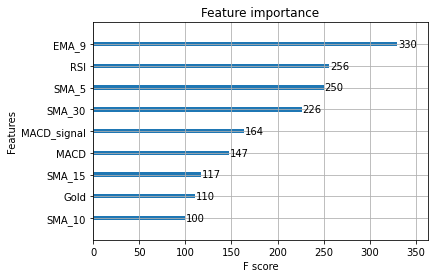

In [64]:
a.train()

In [65]:
plot_prediction(a)